## Import libraries

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D)
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Digit regconizer

## Traditional Machine learning

### Data import

In [11]:
train_master = pd.read_csv("../Assignment 1/digit-recognizer/train.csv")
test_master = pd.read_csv("../Assignment 1/digit-recognizer/test.csv")

train = train_master.copy().drop("label", axis=1)
label = train_master.label
test = test_master.copy()

In [12]:
print(train.shape)
print(label.shape)
print(test.shape)

(42000, 784)
(42000,)
(28000, 784)


### Splitting data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=42)
print(X_train.shape)
print(type(X_train))
print(X_test.shape)
print(type(X_test))

(33600, 784)
<class 'pandas.core.frame.DataFrame'>
(8400, 784)
<class 'pandas.core.frame.DataFrame'>


### Train model

In [21]:
knn = KNeighborsClassifier(n_neighbors=1)
#knn.fit(X, y)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [41]:
y_pred = knn.predict(X_test.to_numpy())
print(y_pred)

/Users/raydi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


[8 1 9 ... 3 0 9]


### Evaluation

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       816
           1       0.97      1.00      0.98       909
           2       0.98      0.95      0.97       846
           3       0.97      0.96      0.96       937
           4       0.98      0.97      0.97       839
           5       0.96      0.96      0.96       702
           6       0.98      0.99      0.98       785
           7       0.96      0.97      0.96       893
           8       0.98      0.94      0.96       835
           9       0.94      0.96      0.95       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



The digit is 7


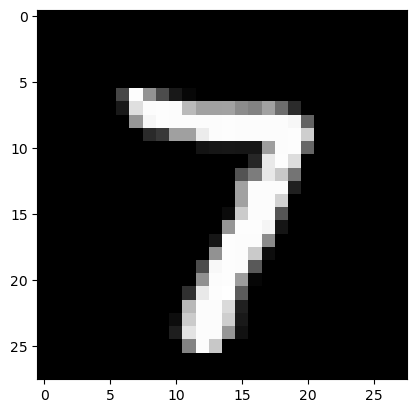

In [42]:
plt.imshow(X_test.iloc[1200].values.reshape(28, 28), cmap="gray")
print(f'The digit is {y_pred[1200]}')

## CNN

In [26]:
X_train_norm = X_train / 255
X_test_norm = X_test / 255

In [36]:
n_classes = 10

Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)

In [38]:
model = Sequential()
# hidden layer
model.add(Dense(100, input_shape=(784,), activation='relu'))
# output layer
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.fit(X_train_norm, Y_train, batch_size=64, epochs=10, validation_data=(X_test_norm, Y_test))

Epoch 1/10
525/525 [==============================] - 1s 825us/step - loss: 0.3799 - accuracy: 0.8955 - val_loss: 0.2267 - val_accuracy: 0.9338
Epoch 2/10
525/525 [==============================] - 0s 687us/step - loss: 0.1815 - accuracy: 0.9480 - val_loss: 0.1667 - val_accuracy: 0.9512
Epoch 3/10
525/525 [==============================] - 0s 665us/step - loss: 0.1330 - accuracy: 0.9629 - val_loss: 0.1414 - val_accuracy: 0.9592
Epoch 4/10
525/525 [==============================] - 0s 692us/step - loss: 0.1044 - accuracy: 0.9707 - val_loss: 0.1244 - val_accuracy: 0.9642
Epoch 5/10
525/525 [==============================] - 0s 718us/step - loss: 0.0859 - accuracy: 0.9750 - val_loss: 0.1169 - val_accuracy: 0.9650
Epoch 6/10
525/525 [==============================] - 0s 818us/step - loss: 0.0700 - accuracy: 0.9796 - val_loss: 0.1095 - val_accuracy: 0.9661
Epoch 7/10
525/525 [==============================] - 0s 866us/step - loss: 0.0580 - accuracy: 0.9837 - val_loss: 0.1053 - val_accuracy:

263/263 [==============================] - 0s 324us/step
The digit is 8


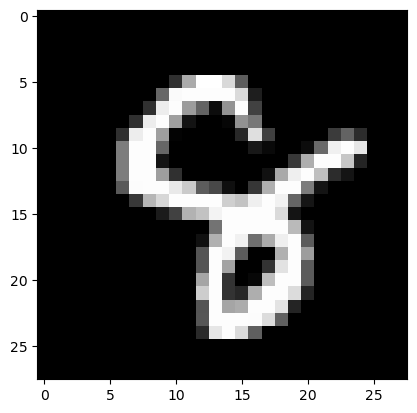

In [46]:
y_pred_cnn = model.predict(X_test)
plt.imshow(X_test.iloc[1900].values.reshape(28, 28), cmap="gray")
print(f'The digit is {np.argmax(y_pred_cnn[1900])}')

# Dog breed

## Traditional machine learning

## CNN